# HW 5 - CS 498 AML

## Aaron Blythe
## Dan Barker

## Page 1 Experiment table

Higher numbers:

| Size of the fixed length sample | Overlap (0-X%) | K-value | Classifier | Accuracy (%) | Error Rate(%) |
|---|---|---|---|---|---|
| 96 | 92 | 280 | Random Forest | 79.23 | 20.77 |
| 96 | 92 | 480 | Random Forest | 79.11 | 20.89 |
| 96 | 92 | 680 | Random Forest | 78.84 | 21.16 |
| 192 | 96 | 280 | Random Forest | 78.24 | 21.76 |
| 192 | 96 | 480 | Random Forest | 78.63 | 21.37 |
| 192 | 96 | 680 | Random Forest | 78.51 | 21.49 |
| 288 | 97 | 280 | Random Forest | 79.10 | 20.90 |
| 288 | 97 | 480 | Random Forest | 79.91 | 20.09 |
| 288 | 97 | 680 | Random Forest | 78.26 | 21.74 |



Standard K-Means was used in all examples.

NOTE 1: Lower numbers for K-value and cluster size also included in code output below
NOTE 2: Larger numbers took longer to run
NOTE 3: experimentation found different values on subsequent runs. This was the best representation of multiple runs on Google Colaboratory

\pagebreak

# Page 2 Histograms

K of 480 and cluster size of 288 was used since it had the highest accuracy in the table.

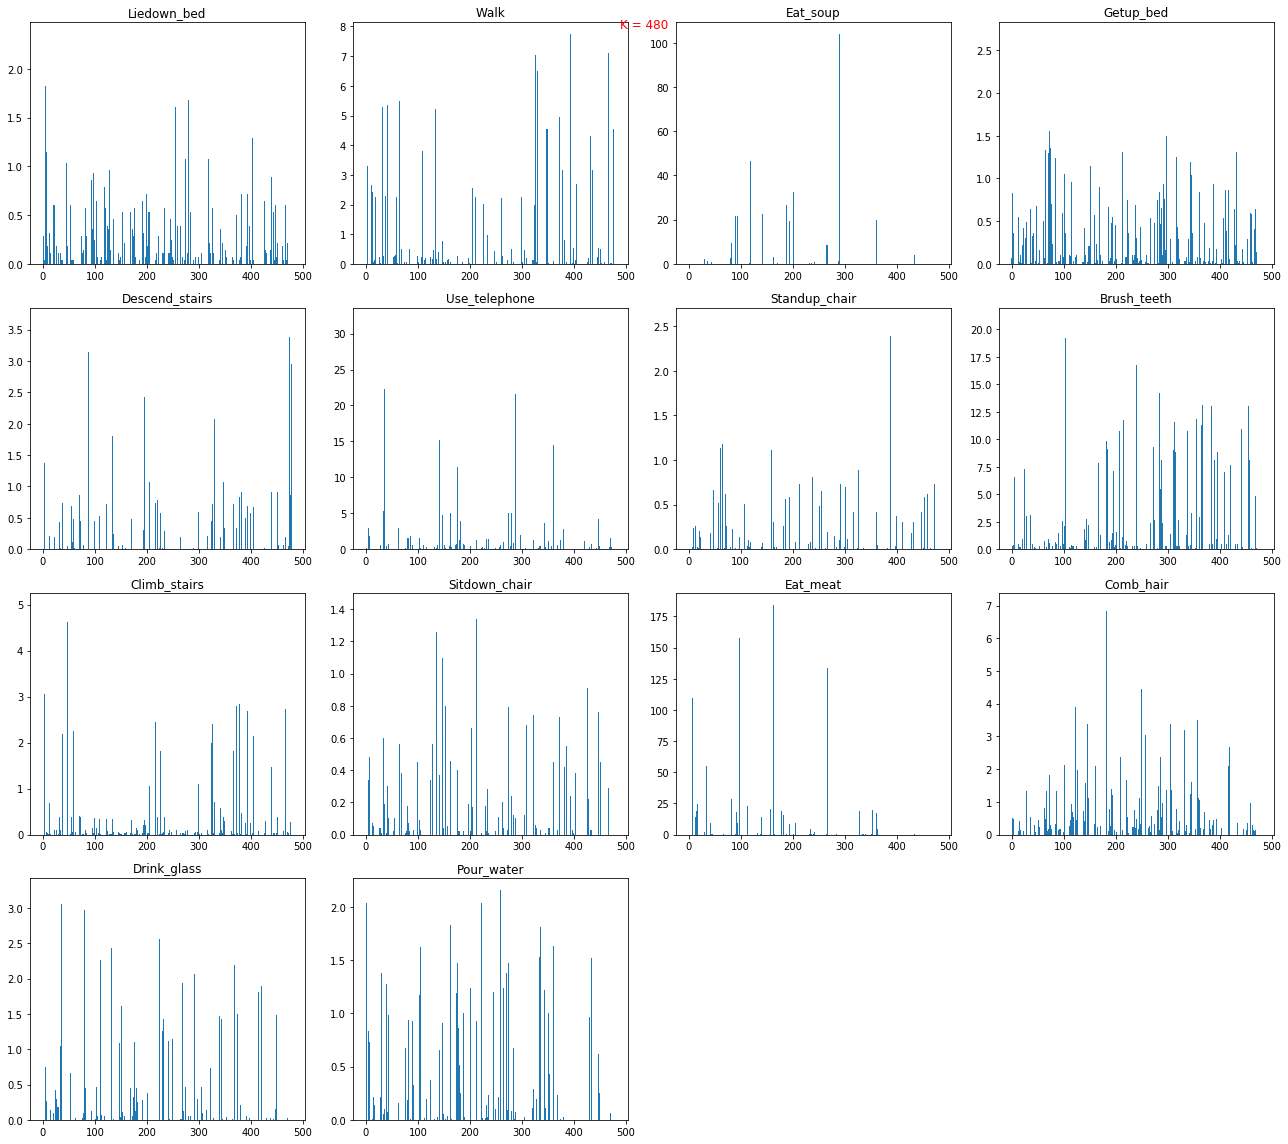

In [77]:
cluster_size = 288
k_value = 480
offset = 8
overlap = cluster_size - offset

#vectorized, hist_data = kmeans(cluster_size, k_value, offset)
plot_histogram(hist_data, data_activities)

\pagebreak

# Page 3 Confusion matrix

cluster size: 288 k value: 480 offset: 8 overlap percent: 97.22
average accuracy (percent): 72.69
best folding set:  2


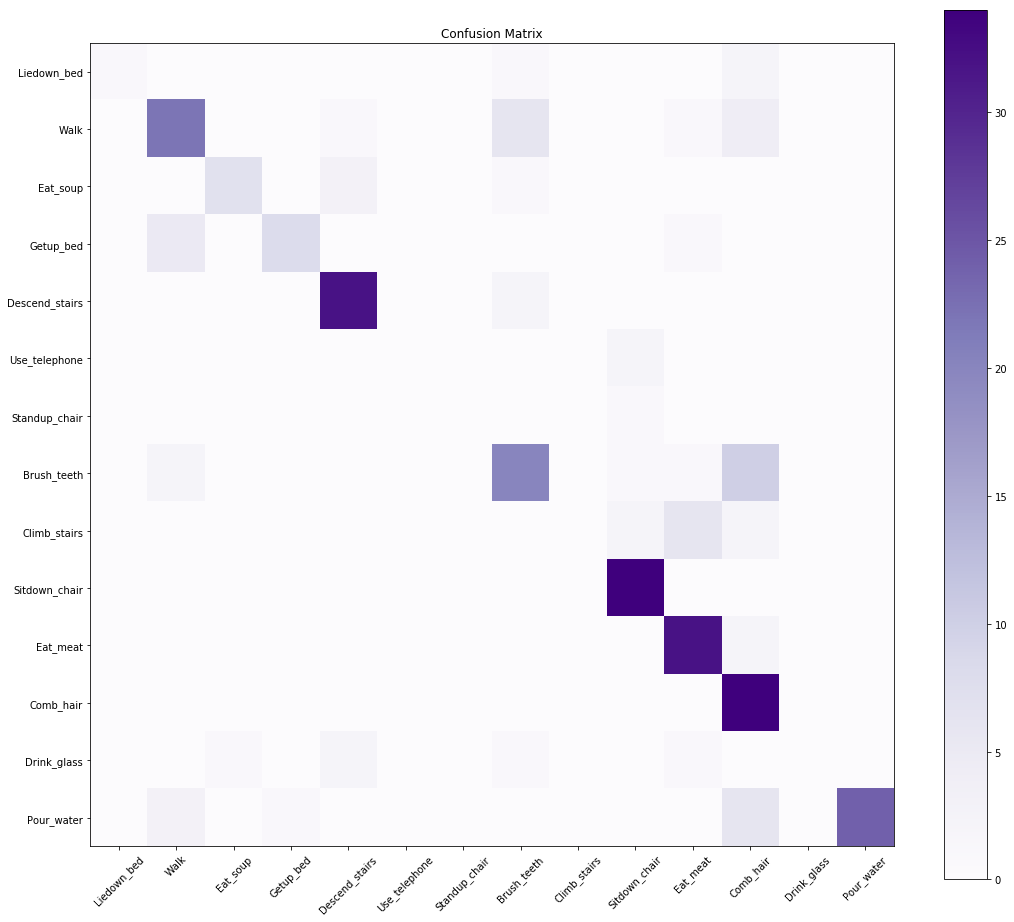

In [78]:
print('cluster size: {0} k value: {1} offset: {2} overlap percent: {3:.2f}'.format(cluster_size, k_value, offset, 100*overlap/cluster_size))
best_folding, accuracy, best_test_label, best_predict_label = best_fold_accuracy()
print("average accuracy (percent): %.2f" % accuracy)
print('best folding set: ', best_folding)
conf_matrix(best_test_label, best_predict_label)

\pagebreak

# Page 4 A screenshot of your code
The page should contain snippets of code demonstrating:

### i) Segmentation of the vector
```python
    for i in range(0, len(lines_stack), offset):
        if i+cluster_size >= len(lines_stack):
            break
        chunk = lines_stack[i: i+cluster_size]
        all_data.append(chunk)
        single_chunks.append(chunk)
```
### ii) K-means
```python
    all_data, activities, file_cnt = read_data(cluster_size, offset)
    cluster = KMeans(n_clusters=k_value)
    kmeans_model = cluster.fit(all_data)
```
### iii) Generating the histogram
```python
    histogram = {}
    vectorized = {}
    for act in activities:
        features = pd.Series(kmeans_model.predict(act.data))
        features = features.value_counts()
        counts = pd.Series(features, index=range(k_value))
        counts = counts.fillna(0)
        if act.label not in vectorized:
            vectorized[act.label] = []
        vectorized[act.label].append(ActivityInstance(counts, act.file, act.label))

        per_file_count = counts / file_cnt[act.label]
        if act.label in histogram:
            df = histogram[act.label]
            per_file_count = per_file_count.add(df)
        histogram[act.label] = per_file_count
```
### iv) Classification
```python
def train(fold, x, y, z):
    # ...
    train_label = [act.label for act in train_set]
    test_label = [act.label for act in test_set]
    rfc = RFC(n_estimators=100, max_depth=7).fit(train_x, train_label)
    predict_label = rfc.predict(test_x)
```

\pagebreak

    
# Page 5 Rest of code

In [61]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier as RFC
import matplotlib.pyplot as plt
import math
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# debugging
import logging, sys
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
#logger.setLevel(logging.WARNING)

In [62]:
# Load the Drive helper and mount
#from google.colab import drive

# This will prompt for authorization.
#drive.mount('/content/drive')

# Obtain the actitivities of daily life dataset from the UC Irvine machine learning website
# (https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer
import os
#print(os.getcwd())
#os.listdir('/content/drive/My Drive/Colab Notebooks/data')
# should have a folder HMP_Dataset for the next part to work

#directories = '/content/drive/My Drive/Colab Notebooks/data/HMP_Dataset/'
directories = 'HMP_Dataset/'
directories_of_data = os.listdir(directories)

# Ignore the directories with MODEL in the name. They are duplicates.
data_directories = [f for f in directories_of_data if 'MODEL' not in f]
# https://stackoverflow.com/questions/2514961/remove-all-values-within-one-list-from-another-list
data_activities = [f for f in data_directories if f not in ['.DS_Store', 'MANUAL.txt', 'displayTrial.m', 'displayModel.m', 'readme.txt', 'README.txt']]

logging.info(data_activities)

number_of_activities = 14

INFO:root:['Liedown_bed', 'Walk', 'Eat_soup', 'Getup_bed', 'Descend_stairs', 'Use_telephone', 'Standup_chair', 'Brush_teeth', 'Climb_stairs', 'Sitdown_chair', 'Eat_meat', 'Comb_hair', 'Drink_glass', 'Pour_water']


In [63]:
class ActivityInstance:
  def __init__(self, data, file, label):
    self.label = label
    self.file = file
    self.data = data

In [64]:
def read_data(cluster_size, offset):
  activities = []
  all_data = []
  number_files = {}
    
  for activity in data_activities:
    path = os.path.join(directories + activity)
    files = os.listdir(path)
    file_count = 0
    for file in files:
      file_count += 1
      with open(os.path.join(path + "/" + file), 'r') as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        lines_stack = []
        single_chunks = []
        for line in lines:
          result = line.split(' ')
          result = list(map(int, result))
          lines_stack.extend(result)

        # "overlap" the data
        # https://www.pythoncentral.io/pythons-range-function-explained/
        # from 0 to number of line start, do next one on the "offset"
        for i in range(0, len(lines_stack), offset):
          if i+cluster_size >= len(lines_stack):
            break
          chunk = lines_stack[i: i+cluster_size]
          all_data.append(chunk)
          single_chunks.append(chunk)
        file_data = ActivityInstance(single_chunks, f, activity)
        activities.append(file_data)
    number_files[activity] = file_count
  logging.debug("all_data length: %s shape is: %s first element: %s", len(all_data), np.shape(all_data), all_data[0])
  logging.debug("activities length: %s shape is: %s first element: %s", len(activities), np.shape(activities), activities[0])
  logging.debug("number_files length: %s values are %s", len(number_files), number_files.values())
  return all_data, activities, number_files

In [81]:
def kmeans(cluster_size, k_value, offset):
  all_data, activities, file_cnt = read_data(cluster_size, offset)
  cluster = KMeans(n_clusters=k_value)
  kmeans_model = cluster.fit(all_data)
  histogram = {}
  vectorized = {}
  for act in activities:
    features = pd.Series(kmeans_model.predict(act.data))
    features = features.value_counts()
    counts = pd.Series(features, index=range(k_value))
    counts = counts.fillna(0)
    if act.label not in vectorized:
      vectorized[act.label] = []
    vectorized[act.label].append(ActivityInstance(counts, act.file, act.label))

    per_file_count = counts / file_cnt[act.label]
    
    if act.label in histogram:
      df = histogram[act.label]
      per_file_count = per_file_count.add(df)
    histogram[act.label] = per_file_count

  #logging.info("vectorized length: %s", len(vectorized))
  #logging.info("histogram length: %s", len(histogram))
  return vectorized, histogram

In [73]:
def plot_histogram(hist_data, data_activities):
  fig = plt.figure(figsize=(18, 16))
  i = 0
  for act_name in data_activities:
    plt.subplot(4, 4, i+1)
    i += 1
    plt.bar(range(k_value), hist_data[act_name])
    plt.title(act_name)
  
  fig.suptitle('K = ' + str(k_value), color = 'r')
  fig.tight_layout()
  plt.show
  

In [67]:
def train(fold, x, y, z):
  train_set = fold[x] + fold[y]
  test_set = fold[z]
  train_x = [act.data for act in train_set]
  test_x = [act.data for act in test_set]
  train_label = [act.label for act in train_set]
  test_label = [act.label for act in test_set]
  rfc = RFC(n_estimators=100, max_depth=7).fit(train_x, train_label)
  predict_label = rfc.predict(test_x)
  correct = 0
  for actual, pred in zip(test_label, predict_label):
    if actual == pred:
      correct += 1
  accuracy = correct / len(predict_label)
  #logging.info("fold accuracy: %s", accuracy)
  accuracy = accuracy*100
  #print("fold accuracy (percent): %.2f" % accuracy)
  logging.debug("test_label length: %s shape is: %s first element: %s", len(test_label), np.shape(test_label), test_label[0])
  logging.debug("predict_label length: %s shape is: %s first element: %s", len(predict_label), np.shape(predict_label), predict_label[0])
  return accuracy, test_label, predict_label

In [68]:
def conf_matrix(test_label, predict_label):
  plt.close()
  fig, ax = plt.subplots(figsize=(18, 16))
  cm = confusion_matrix(test_label, predict_label)
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)
  plt.title("Confusion Matrix")
  plt.xticks(np.arange(0, 14, 1.0))
  plt.yticks(np.arange(0, 14, 1.0))
  
  
  ax.set_xticklabels(data_activities, rotation=45)
  ax.set_yticklabels(data_activities)
  plt.colorbar()
  plt.show()

In [69]:
def best_fold_accuracy():
  folds = [[], [], []]

  for act_name in data_activities:
    labels = vectorized[act_name]
    numbers = math.ceil(len(labels) / 3)
    folds[0].extend(labels[: int(numbers)])
    folds[1].extend(labels[int(numbers): int(numbers*2)])
    folds[2].extend(labels[int(numbers*2):])

  accuracy = 0
  max_accuracy = 0
  best_folding = 0
  best_test_label = []
  best_predict_label = []
  fold_accuracy, test_label, predict_label = train(folds, 0, 1, 2)
  accuracy += fold_accuracy / 3
  if fold_accuracy > max_accuracy:
    best_folding = 0
    max_accuracy = fold_accuracy
    best_test_label = test_label
    best_predict_label = predict_label
  fold_accuracy, test_label, predict_label = train(folds, 1, 2, 0)
  accuracy += fold_accuracy / 3
  if fold_accuracy > max_accuracy:
    best_folding = 1
    max_accuracy = fold_accuracy
    best_test_label = test_label
    best_predict_label = predict_label
  fold_accuracy, test_label, predict_label = train(folds, 2, 0, 1)
  accuracy += fold_accuracy / 3
  if fold_accuracy > max_accuracy:
    best_folding = 2
    max_accuracy = fold_accuracy
    best_test_label = test_label
    best_predict_label = predict_label
  logging.debug("test_label length: %s shape is: %s first element: %s", len(test_label), np.shape(test_label), test_label[0])
  logging.debug("predict_label length: %s shape is: %s first element: %s", len(predict_label), np.shape(predict_label), predict_label[0])  
  return best_folding, accuracy, best_test_label, best_predict_label

In [ ]:
cluster_size = 288
k_value = 480
offset = 8
overlap = cluster_size - offset

vectorized, hist_data = kmeans(cluster_size, k_value, offset)
plot_histogram(hist_data, data_activities)


cluster size:  288
k value:  480
offset:  8
overlap percent: 97.22222222222223
average accuracy (percent): 73.04
best folding set:  1


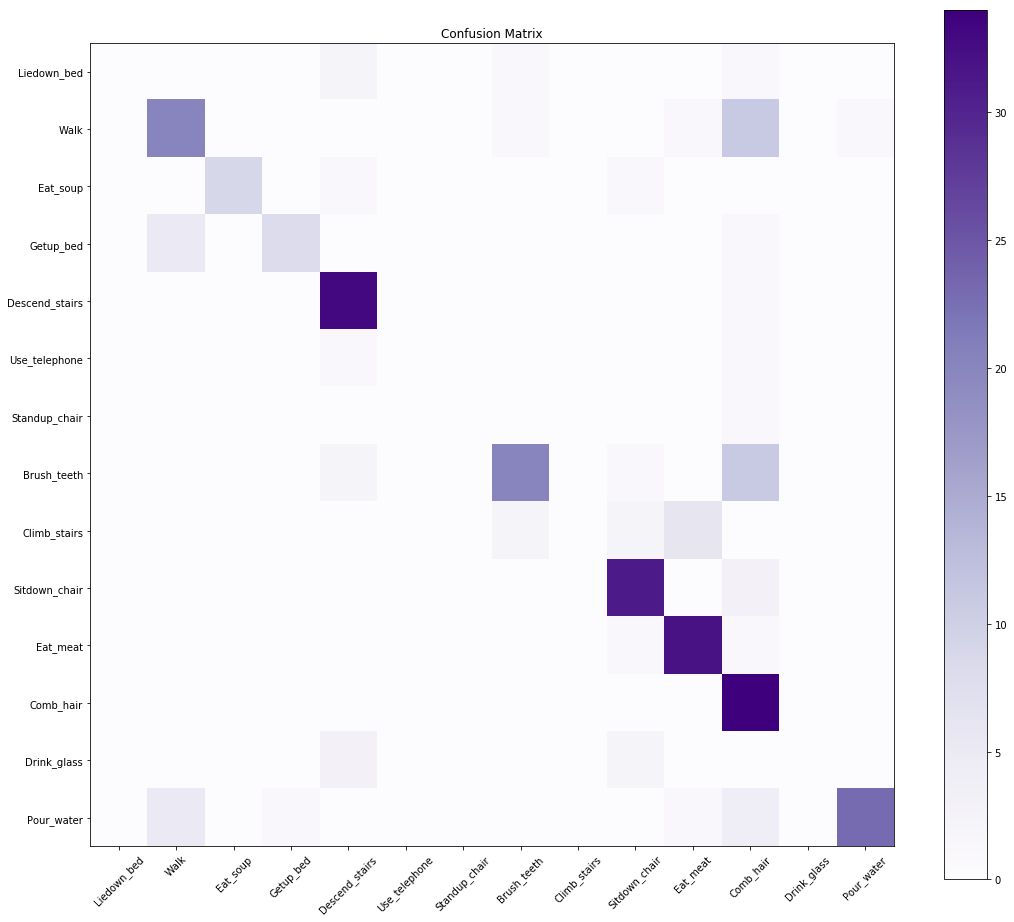

In [75]:
print('cluster size: ', cluster_size)
print('k value: ', k_value)
print('offset: ', offset)
print('overlap percent:', 100*overlap/cluster_size)

best_folding, accuracy, best_test_label, best_predict_label = best_fold_accuracy()

print("average accuracy (percent): %.2f" % accuracy)
print('best folding set: ', best_folding)

conf_matrix(best_test_label, best_predict_label)

In [84]:
vectorized_datas = {}
histograms = {}

output_tables = []
headers = ["Cluster Size", "Overlap (0-X%)", "K-value", "Classifier", "Accuracy (%)", "Error Rate (%)"]

logging.info("| Size of the fixed length sample | Overlap (0-X%) | K-value | Classifier | Accuracy (%) | Error Rate (%) |")

for cluster_size in range(24, 36, 4):
  for k_value in range(10, 20 , 4):
    overlap = cluster_size - offset
    output = []
    i_j = str(cluster_size) + "_" + str(k_value)
    vectorized_datas[i_j], histograms[i_j] = kmeans(cluster_size, k_value, offset)
    best_folding, accuracy, best_test_label, best_predict_label = best_fold_accuracy()
    error_rate = 1 - accuracy
    logging.info("| {0} | {1:.2f} | {2} | Random Forest | {3:.2f} |".format(str(cluster_size), 100*overlap/cluster_size, str(k_value), accuracy))
    #print("| {0} | {1:.2f} | {2} | Random Forest | {3:.2f} | {3:.2f} |".format(str(cluster_size), overlap/cluster_size, str(k_value), accuracy, error_rate))
    output.append(cluster_size)
    output.append(overlap/cluster_size)
    output.append(k_value)
    output.append("Random Forest")
    output.append(accuracy)
    output.append(error_rate)
    output = np.array(output)
    output_tables.append(output)
    
output_tables = np.array(output_tables)

INFO:root:| Size of the fixed length sample | Overlap (0-X%) | K-value | Classifier | Accuracy (%) | Error Rate (%) |
INFO:root:| 24 | 66.67 | 10 | Random Forest | 73.17 |
INFO:root:| 24 | 66.67 | 14 | Random Forest | 72.56 |
INFO:root:| 24 | 66.67 | 18 | Random Forest | 73.16 |
INFO:root:| 28 | 71.43 | 10 | Random Forest | 72.80 |
INFO:root:| 28 | 71.43 | 14 | Random Forest | 73.05 |
INFO:root:| 28 | 71.43 | 18 | Random Forest | 72.10 |
INFO:root:| 32 | 75.00 | 10 | Random Forest | 72.53 |
INFO:root:| 32 | 75.00 | 14 | Random Forest | 73.16 |
INFO:root:| 32 | 75.00 | 18 | Random Forest | 72.81 |


In [85]:
table = tabulate(output_tables, headers, tablefmt="fancy_grid")
print(table)

╒════════════════╤══════════════════╤═══════════╤═══════════════╤════════════════╤══════════════════╕
│   Cluster Size │   Overlap (0-X%) │   K-value │ Classifier    │   Accuracy (%) │   Error Rate (%) │
╞════════════════╪══════════════════╪═══════════╪═══════════════╪════════════════╪══════════════════╡
│             24 │         0.666667 │        10 │ Random Forest │        73.1694 │         -72.1694 │
├────────────────┼──────────────────┼───────────┼───────────────┼────────────────┼──────────────────┤
│             24 │         0.666667 │        14 │ Random Forest │        72.5638 │         -71.5638 │
├────────────────┼──────────────────┼───────────┼───────────────┼────────────────┼──────────────────┤
│             24 │         0.666667 │        18 │ Random Forest │        73.1625 │         -72.1625 │
├────────────────┼──────────────────┼───────────┼───────────────┼────────────────┼──────────────────┤
│             28 │         0.714286 │        10 │ Random Forest │        72.8046 │